# Can We Predict The Star Type

With ML techniques, we can categorize the stars between dwarfs and giants stars.

* Tasks you can do:
1. Preprocess the Data
    - Clean the Data (Null values, Errored values)

    
    
2. Analysis and Predict Star Type
    - Try different models
    - Performing deep neural network and create a decision boundary

In [565]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  
    target_cell = this_cell  
    js_hide_current = ''

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# 1. Process the Data 

#### Imporing Libraries

In [566]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image, display
from PIL import Image
hide_toggle()

In [567]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
hide_toggle()

In [568]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes import jtplot

#### Loading dataset

In [569]:
raw = pd.read_csv('../Star-Classification/Star99999_raw.csv')

#### Exploring dataset

In [570]:
raw.head()

Unnamed: 0   Vmag      Plx   e_Plx     B-V SpType
0           0   9.10     3.54    1.39   0.482     F5
1           1   9.27    21.90    3.10   0.999    K3V
2           2   6.61     2.81    0.63  -0.019     B9
3           3   8.06     7.75    0.97   0.370    F0V
4           4   8.55     2.87    1.11   0.902  G8III

#### Columns:

Vmag - Visual Apparent Magnitude of the Star (m)

Plx - Distance Between the Star and the Earth (d)

e_Plx - Standard Error of Plx (Drop the Row if you find the e_Plx is too high!)

B-V - B-V color index. (A hot star has a B-V color index close to 0 or negative, while a cool star has a B-V color index close to 2.0. Other stars are somewhere in between.)

SpType - Stellar classification.

In [571]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  99999 non-null  int64 
 1   Vmag        99999 non-null  object
 2   Plx         99999 non-null  object
 3   e_Plx       99999 non-null  object
 4   B-V         99999 non-null  object
 5   SpType      97377 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


# - Data Cleaning

#### Unnamed: 0 is a index columns :

but we already have it so let's dropt it


In [572]:
raw.drop('Unnamed: 0', axis = 1, inplace = True)

raw.head()

Vmag      Plx   e_Plx     B-V SpType
0   9.10     3.54    1.39   0.482     F5
1   9.27    21.90    3.10   0.999    K3V
2   6.61     2.81    0.63  -0.019     B9
3   8.06     7.75    0.97   0.370    F0V
4   8.55     2.87    1.11   0.902  G8III

#### Let's change the columns name to better manipulation

In [573]:
raw.rename(columns={'B-V':'B_V'}, inplace = True)

In [574]:
raw.query('B_V == "      "')

Vmag      Plx   e_Plx     B_V   SpType
44      9.59    15.10    1.92          G6/G8V:
52     10.96    -1.76    2.45              NaN
319    12.14     6.48    4.13              F1:
374     9.08     6.13    1.59              NaN
389    11.67     4.86    2.61               F7
...      ...      ...     ...     ...      ...
99525   8.71                               NaN
99665   9.25     5.97    3.05              NaN
99701  10.46    23.91    1.78               K0
99770   9.53                               NaN
99915  10.51                               NaN

[1128 rows x 5 columns]

#### converting object type columns to numeric

In [575]:
raw.Vmag = pd.to_numeric(raw.Vmag, downcast='float', errors ='coerce')
raw.Plx = pd.to_numeric(raw.Plx, downcast='float', errors ='coerce')
raw.e_Plx = pd.to_numeric(raw.e_Plx, downcast='float', errors ='coerce')
raw['B_V'] = pd.to_numeric(raw['B_V'], downcast='float', errors ='coerce')

In [576]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    99998 non-null  float32
 1   Plx     99768 non-null  float32
 2   e_Plx   99768 non-null  float32
 3   B_V     98871 non-null  float32
 4   SpType  97377 non-null  object 
dtypes: float32(4), object(1)
memory usage: 2.3+ MB


In [577]:
raw.describe().T

count      mean        std        min    25%    50%    75%  \
Vmag   99998.0  8.369750   1.313896  -1.440000  7.640  8.440  9.140   
Plx    99768.0  7.212467  11.348988 -54.950001  2.510  4.630  8.410   
e_Plx  99768.0  1.365385   1.816838   0.380000  0.880  1.100  1.390   
B_V    98871.0  0.704726   0.489679  -0.400000  0.348  0.612  1.075   

              max  
Vmag    14.080000  
Plx    772.330017  
e_Plx  114.459999  
B_V      5.460000

#### Checking for missing values

In [578]:
raw.isnull().sum()

Vmag         1
Plx        231
e_Plx      231
B_V       1128
SpType    2622
dtype: int64

In [579]:
raw.shape

(99999, 5)

#### What is the % of the missing data

In [580]:
total_cells = np.product(raw.shape)
total_missing = raw.isnull().sum().sum()
percent_missing = (total_missing/total_cells)* 100

In [581]:
print(f'Missing data equals: {round(percent_missing,2)}%' )

Missing data equals: 0.84%


#### Pourcentage insignificant, so lets drop those rows

In [582]:
raw_missing_removed = raw.dropna()

In [583]:
raw_missing_removed.shape

(96742, 5)

In [584]:
raw_missing_removed.isnull().sum()

Vmag      0
Plx       0
e_Plx     0
B_V       0
SpType    0
dtype: int64

#### How many rows did we dropped?

In [585]:
dropped_rows = raw.shape[0] - raw_missing_removed.shape[0]

In [586]:
print(f'We dropped : {dropped_rows} rows')

We dropped : 3257 rows


#### What is the pourcentage of this amount? 

In [587]:
pourcentage_dropped_rows = ((raw.shape[0] - raw_missing_removed.shape[0])/raw.shape[0])*100

In [588]:
print(f'Dropped rows equals : {round(pourcentage_dropped_rows,2)} %')

Dropped rows equals : 3.26 %


#### Checking for duplicated

In [589]:
raw_missing_removed.duplicated().sum()

0

#### But after dropping so many rows our index must be weird

#### Let's ReIndex it

In [590]:
raw_missing_removed.reset_index(drop=True, inplace = True)

In [591]:
raw_missing_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96742 entries, 0 to 96741
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    96742 non-null  float32
 1   Plx     96742 non-null  float32
 2   e_Plx   96742 non-null  float32
 3   B_V     96742 non-null  float32
 4   SpType  96742 non-null  object 
dtypes: float32(4), object(1)
memory usage: 2.2+ MB


In [592]:
raw_missing_removed.describe().T

count      mean        std        min    25%    50%    75%  \
Vmag   96742.0  8.291918   1.247995  -1.440000  7.610  8.400  9.070   
Plx    96742.0  7.105242  11.145643 -35.099998  2.520  4.600  8.270   
e_Plx  96742.0  1.264163   1.156202   0.380000  0.870  1.080  1.360   
B_V    96742.0  0.700663   0.490053  -0.400000  0.342  0.605  1.072   

              max  
Vmag    13.610000  
Plx    772.330017  
e_Plx   69.070000  
B_V      5.460000


## First Part Data Cleaned 

### Let's Find Some Features of the Stars

New Columns : 

Plx = Parallax Distance Between the Star and the Earth (arsec) 

Distance = Distance Between the Star and the Earth (parsec)

ly = Distance Between the Star and Earth (light years)

Amag = Absolute Magnitude of the Star (mag)

Temperature = Temperature Effective considering the star as a perfect black body (kelvin)

Luminosity = Star's luminosity (watts)

Luminosity(Sun=1) = Star's luminosity in the terms of the luminosity of the Sun (watts)

Mass(Sun=1) = Star's Mass in the terms of the Mass of the Sun (solar mass)

Radius(Sun) = Star's Radius in the terms of the Radius of the Sun (solar mass)

Radius = Star's Radius (meters)

#### Some Equations asks for log of Plx(d) (which is the distance between the star and the Earth)
#### But log of 0 is infinite and we can't use it

So let's not consider theses rows

In [593]:
# Seeing how many zeros we have in Plx

raw_missing_removed.query("Plx == 0")

Vmag  Plx  e_Plx    B_V    SpType
945     8.68  0.0   1.19  1.290     K2III
1413    7.63  0.0   0.77  0.267   B1II...
18219  10.09  0.0   1.84  0.190        A0
23867  10.75  0.0   1.21 -0.012         B
26477   9.01  0.0   1.40  0.089        B8
29457   8.44  0.0   1.26  0.042     B1Vne
29968   6.57  0.0   0.89  0.121     A0III
36969   7.90  0.0   0.99  1.745         S
37320   8.24  0.0   1.29  1.341        K0
39917   9.28  0.0   1.60  0.956         G
41869   8.87  0.0   1.22  1.638      M...
42858   9.20  0.0   1.15  0.293        A2
47633   9.18  0.0   1.12  1.004        G5
48636  10.95  0.0   1.67  0.272      A8.7
49573   9.36  0.0   0.86  0.010       B9V
49658   8.26  0.0   0.87  0.681      F2II
59357  10.97  0.0   2.21  0.184       A3V
61404   9.00  0.0   1.30  1.065     G8III
61695   8.00  0.0   0.88  1.576  K2II/III
62922   6.00  0.0   0.78  0.236    B0.5Ia
64666   8.94  0.0   1.31  0.110      B9IV
65552   5.83  0.0   0.84 -0.053    B2IIIe
66660   9.00  0.0   1.23  0.026    B8IV/V
75644   9.50  0.0   1.52  0.949        K0
77888  10.34  0.0   2.02  1.246        K0
83929   9.23  0.0   1.02  1.665        M0
84040   8.84  0.0   1.17  0.134        B8
85938   6.53  0.0   0.85 -0.059   B1/B2Ib
86937  10.29  0.0   2.36  0.169        A0
87228   6.61  0.0   1.14  0.778      B1Ia
88274   9.49  0.0   1.69  1.500        G1
88909   8.20  0.0   1.15  0.925    B0.5Ia
92075   6.99  0.0   0.98  1.022        C0
92710   9.15  0.0   1.47  1.631     K4III
93323  10.01  0.0   2.10  1.500   M6e-M8e

In [594]:
# Choosing only the rows with Plx different than zero

raw_missing_removed = raw_missing_removed.query('Plx != 0')

In [595]:
raw_missing_removed.shape

(96707, 5)

In [596]:
# Confirming that there is no more Plx zero left

raw_missing_removed.query('Plx == 0')

Empty DataFrame
Columns: [Vmag, Plx, e_Plx, B_V, SpType]
Index: []

In [597]:
# reindexing the dataframe

raw_missing_removed.reset_index(drop = True, inplace = True)

In [598]:
raw_missing_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96707 entries, 0 to 96706
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    96707 non-null  float32
 1   Plx     96707 non-null  float32
 2   e_Plx   96707 non-null  float32
 3   B_V     96707 non-null  float32
 4   SpType  96707 non-null  object 
dtypes: float32(4), object(1)
memory usage: 2.2+ MB


In [599]:
raw_missing_removed.describe().T

count      mean        std        min    25%    50%    75%  \
Vmag   96707.0  8.291762   1.247954  -1.440000  7.610  8.400  9.070   
Plx    96707.0  7.107813  11.146737 -35.099998  2.520  4.600  8.270   
e_Plx  96707.0  1.264152   1.156387   0.380000  0.870  1.080  1.360   
B_V    96707.0  0.700663   0.490001  -0.400000  0.342  0.605  1.072   

              max  
Vmag    13.610000  
Plx    772.330017  
e_Plx   69.070000  
B_V      5.460000

In [600]:
# assigning the actual dataframe to simpler variable for better manipulation
df = raw_missing_removed.copy()


#### The Plx is in Milliarcsecond (mas) and we need it in arcsecond (arsec)

#### 1 mas = 0.00099999995874704 arcsec.


#### 1 pc = 1 arsecs (arcsecond)


In [601]:
# converting to arsec

df['Plx'] = df.Plx.map(lambda x : x*0.00099999995874704)

In [602]:
df.describe().T

count      mean       std     min      25%     50%      75%       max
Vmag   96707.0  8.291762  1.247954 -1.4400  7.61000  8.4000  9.07000  13.61000
Plx    96707.0  0.007108  0.011147 -0.0351  0.00252  0.0046  0.00827   0.77233
e_Plx  96707.0  1.264152  1.156387  0.3800  0.87000  1.0800  1.36000  69.07000
B_V    96707.0  0.700663  0.490001 -0.4000  0.34200  0.6050  1.07200   5.46000


#### we can get the distance in light years to faciliate the reading later

#### to get the light years we need to get the distance modulus from its Plx 


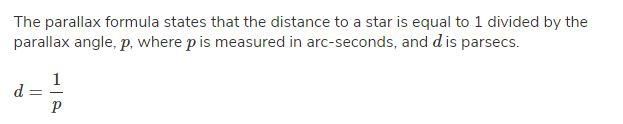

In [603]:
display(Image.open('../Star-Classification/Distance_by_Plx.JPG'))

In [604]:
# getting te distance modulus
df['Distance'] = df.Plx.map(lambda x : 1/x)

#### 1 parsecs = 3.26 light lyears

In [605]:
# converting the distance parsec in light years
df['ly'] = df['Distance'].map(lambda x : (abs(x)*3.26))

In [606]:
df.describe().T

count         mean           std            min         25%  \
Vmag      96707.0     8.291762      1.247954      -1.440000    7.610000   
Plx       96707.0     0.007108      0.011147      -0.035100    0.002520   
e_Plx     96707.0     1.264152      1.156387       0.380000    0.870000   
B_V       96707.0     0.700663      0.490001      -0.400000    0.342000   
Distance  96707.0   286.335567   3292.193462 -100000.006360  109.890110   
ly        96707.0  1952.241255  10594.701704       4.220994  393.244891   

                 50%          75%            max  
Vmag        8.400000     9.070000      13.610000  
Plx         0.004600     0.008270       0.772330  
e_Plx       1.080000     1.360000      69.070000  
B_V         0.605000     1.072000       5.460000  
Distance  202.429156   361.010848  100000.006360  
ly        705.627752  1278.431449  326000.020735

#### Getting Amag (Absolute Magnitude)

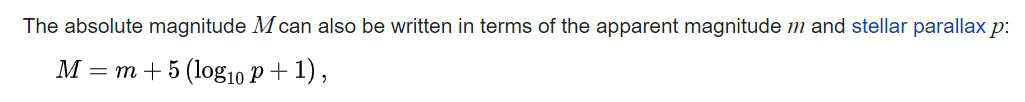

In [607]:
display(Image.open('../Star-Classification/Amag.JPG'))

In [608]:
# getting Absolute Maagnitude

df['Amag'] = df.Vmag + 5 *(np.log10(((df.Plx)))+1)

In [609]:
df.describe().T

count         mean           std            min         25%  \
Vmag      96707.0     8.291762      1.247954      -1.440000    7.610000   
Plx       96707.0     0.007108      0.011147      -0.035100    0.002520   
e_Plx     96707.0     1.264152      1.156387       0.380000    0.870000   
B_V       96707.0     0.700663      0.490001      -0.400000    0.342000   
Distance  96707.0   286.335567   3292.193462 -100000.006360  109.890110   
ly        96707.0  1952.241255  10594.701704       4.220994  393.244891   
Amag      93556.0     1.599608      2.326055     -13.310000    0.263157   

                 50%          75%            max  
Vmag        8.400000     9.070000      13.610000  
Plx         0.004600     0.008270       0.772330  
e_Plx       1.080000     1.360000      69.070000  
B_V         0.605000     1.072000       5.460000  
Distance  202.429156   361.010848  100000.006360  
ly        705.627752  1278.431449  326000.020735  
Amag        1.511542     3.064660      15.449015

#### Getting Temperature Effective from B-V



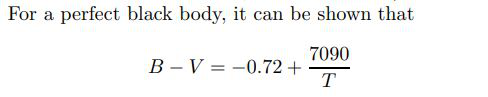

In [610]:
display(Image.open('../Star-Classification/temperature.JPG'))


In [611]:
df['Temperature'] = 7090/(df.B_V + 0.72)



#### Let's calculate luminosity


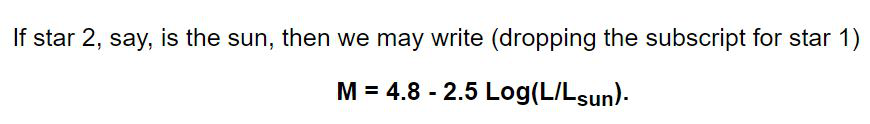

In [612]:
display(Image.open('../Star-Classification/Luminosity.JPG'))


In [613]:
# getting luminosity by the sun luminosity (3.828e+26)

df['Luminosity'] = df.Amag.map(lambda x: 3.828e+26/10**((x-4.8)/2.5))

In [614]:
# considering sun luminosity = 1

df['Luminosity(Sun=1)'] = df.Amag.map(lambda x: 1/10**((x-4.8)/2.5))

#### Getting the Stars Mass


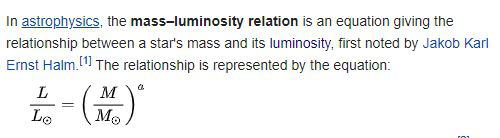

In [615]:
display(Image.open('../Star-Classification/Mass_Luminosity.JPG'))

In [616]:
# getting mass from sun mass and luminosity = 1 

df['Mass(Sun=1)'] = df['Luminosity(Sun=1)']**2/7

#### Let's get Star Radius

Radius sun = 7.35355×10−8 light-year /2.25461×10−8	parsec

Tem sun = 5.778 K

Lum sun = 3.828×e+1026 watts

In [617]:
# we can get the star radius from the sun real values:

df['Radius(sun)'] = df.Luminosity* 7.35355e-8*5.778/3.828e+26*df.Temperature

In [618]:
# we can algo get the radius from it's luminosity and temperature

df['Radius'] = 1181.57*np.sqrt(df.Luminosity) / df.Temperature

In [619]:
df.describe().T

count          mean           std           min  \
Vmag               96707.0  8.291762e+00  1.247954e+00 -1.440000e+00   
Plx                96707.0  7.107773e-03  1.114689e-02 -3.510000e-02   
e_Plx              96707.0  1.264152e+00  1.156387e+00  3.800000e-01   
B_V                96707.0  7.006627e-01  4.900010e-01 -4.000000e-01   
Distance           96707.0  2.863356e+02  3.292193e+03 -1.000000e+05   
ly                 96707.0  1.952241e+03  1.059470e+04  4.220994e+00   
Amag               93556.0  1.599608e+00  2.326055e+00 -1.331000e+01   
Temperature        96707.0  5.685351e+03  2.187985e+03  1.147249e+03   
Luminosity         93556.0  8.568882e+29  3.791047e+31  2.105552e+22   
Luminosity(Sun=1)  93556.0  2.238475e+03  9.903467e+04  5.500398e-05   
Mass(Sun=1)        93556.0  1.401825e+09  1.774229e+11  4.322054e-10   
Radius(sun)        93556.0  5.820296e+00  3.102057e+02  6.557068e-08   
Radius             93556.0  4.571646e+13  2.544964e+14  5.604521e+10   

                            25%           50%           75%           max  
Vmag               7.610000e+00  8.400000e+00  9.070000e+00  1.361000e+01  
Plx                2.520000e-03  4.600000e-03  8.270000e-03  7.723300e-01  
e_Plx              8.700000e-01  1.080000e+00  1.360000e+00  6.907000e+01  
B_V                3.420000e-01  6.050000e-01  1.072000e+00  5.460000e+00  
Distance           1.098901e+02  2.024292e+02  3.610108e+02  1.000000e+05  
ly                 3.932449e+02  7.056278e+02  1.278431e+03  3.260000e+05  
Amag               2.631575e-01  1.511542e+00  3.064660e+00  1.544901e+01  
Temperature        3.956473e+03  5.350943e+03  6.676083e+03  2.215625e+04  
Luminosity         1.892813e+27  7.913258e+27  2.498670e+28  6.713855e+33  
Luminosity(Sun=1)  4.944654e+00  2.067204e+01  6.527352e+01  1.753881e+07  
Mass(Sun=1)        3.492800e+00  6.104762e+01  6.086617e+02  4.394425e+13  
Radius(sun)        1.194030e-02  4.652123e-02  1.441366e-01  6.680848e+04  
Radius             8.654484e+12  1.688555e+13  3.869577e+13  2.834827e+16

### Display Star Classification

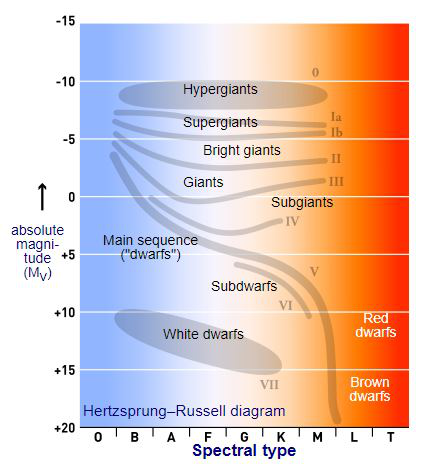

In [620]:
display(Image.open('../Star-Classification/Star_Classification.JPG'))

# - Create a label column via SpType

``` python
def label_amag(star_amag, star_type):
    dwarf_amag = np.arange(2.5, 20, 0.00001)
    giant_amag = np.arange(-20,2.5, 0.00001)
    dwarf_type = ['D','VI', 'VII', 'V']
    giant_type = ['IV', 'III', 'II', 'Ib', 'Ia', 'Ia-O']
    for i in dwarf_type :
        for a in dwarf_amag:
            if i in star_type and round(a,2) == round(star_amag,2):
                print(a)
                return 'Dwarf'
    for i in giant_type:
        for a in giant_amag:
            if i in star_type and round(a,2) == round(star_amag,2):
                return 'Giant'
    return 'Other'

```

In [621]:
def label_gen_stars(star):
    dwarf = ['D','VI', 'VII', 'V']
    giant = ['IV', 'III', 'II', 'Ib', 'Ia', 'Ia-O']
    for i in dwarf :
        if i in star:
            return 'Dwarf'
    for i in giant:
        if i in star:
            return 'Giant'
    return 'Other'
    

In [622]:
df['Star_Type'] = df.SpType.apply(label_gen_stars)

#### We want to predict dwarf and giants stars ( we can desconsider other type)


In [623]:
df.Star_Type.value_counts()

Other    49196
Dwarf    27752
Giant    19759
Name: Star_Type, dtype: int64

In [624]:

df = df.query('Star_Type != "Other"')

df.query('Star_Type == "Other"')

df.Star_Type.value_counts()

Dwarf    27752
Giant    19759
Name: Star_Type, dtype: int64

## Data Cleaning

### Dropping rows that are null

In [625]:
df.isnull().sum()

Vmag                    0
Plx                     0
e_Plx                   0
B_V                     0
SpType                  0
Distance                0
ly                      0
Amag                 1256
Temperature             0
Luminosity           1256
Luminosity(Sun=1)    1256
Mass(Sun=1)          1256
Radius(sun)          1256
Radius               1256
Star_Type               0
dtype: int64

In [626]:
df_clean = df.dropna()

In [627]:
print(f'We dropped : {df.shape[0] - df.dropna().shape[0]} rows')


We dropped : 1256 rows


In [628]:
df_clean.isnull().sum()

Vmag                 0
Plx                  0
e_Plx                0
B_V                  0
SpType               0
Distance             0
ly                   0
Amag                 0
Temperature          0
Luminosity           0
Luminosity(Sun=1)    0
Mass(Sun=1)          0
Radius(sun)          0
Radius               0
Star_Type            0
dtype: int64

In [629]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46255 entries, 1 to 96705
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vmag               46255 non-null  float32
 1   Plx                46255 non-null  float64
 2   e_Plx              46255 non-null  float32
 3   B_V                46255 non-null  float32
 4   SpType             46255 non-null  object 
 5   Distance           46255 non-null  float64
 6   ly                 46255 non-null  float64
 7   Amag               46255 non-null  float64
 8   Temperature        46255 non-null  float64
 9   Luminosity         46255 non-null  float64
 10  Luminosity(Sun=1)  46255 non-null  float64
 11  Mass(Sun=1)        46255 non-null  float64
 12  Radius(sun)        46255 non-null  float64
 13  Radius             46255 non-null  float64
 14  Star_Type          46255 non-null  object 
dtypes: float32(3), float64(10), object(2)
memory usage: 5.1+ MB


### Are there any outliers?

In [630]:
summary = df_clean.describe().T


In [631]:

summary['IQR']=summary['75%']-summary['25%']
summary.head()

summary['IQR']=summary['75%']-summary['25%']
summary

count          mean           std           min  \
Vmag               46255.0  7.939283e+00  1.313916e+00 -6.200000e-01   
Plx                46255.0  7.883509e-03  1.268879e-02  9.999999e-06   
e_Plx              46255.0  1.111427e+00  7.703500e-01  3.800000e-01   
B_V                46255.0  6.919513e-01  4.980702e-01 -4.000000e-01   
Distance           46255.0  4.599750e+02  2.468987e+03  1.294783e+00   
ly                 46255.0  1.499519e+03  8.048899e+03  4.220994e+00   
Amag               46255.0  1.358017e+00  2.338901e+00 -1.306485e+01   
Temperature        46255.0  5.790804e+03  2.362701e+03  1.704327e+03   
Luminosity         46255.0  1.088042e+30  3.983179e+31  2.105552e+22   
Luminosity(Sun=1)  46255.0  2.842326e+03  1.040538e+05  5.500398e-05   
Mass(Sun=1)        46255.0  1.547862e+09  1.451541e+11  4.322054e-10   
Radius(sun)        46255.0  7.945451e+00  3.922793e+02  6.557068e-08   
Radius             46255.0  5.107660e+13  2.782541e+14  5.604521e+10   

                            25%           50%           75%           max  \
Vmag               7.220000e+00  8.180000e+00  8.850000e+00  1.279000e+01   
Plx                2.730000e-03  4.960000e-03  9.050000e-03  7.723300e-01   
e_Plx              8.000000e-01  9.900000e-01  1.240000e+00  4.063000e+01   
B_V                3.230000e-01  6.170000e-01  1.074000e+00  3.440000e+00   
Distance           1.104972e+02  2.016129e+02  3.663004e+02  1.000000e+05   
ly                 3.602210e+02  6.572581e+02  1.194139e+03  3.260000e+05   
Amag               1.417298e-02  1.259997e+00  2.907844e+00  1.544901e+01   
Temperature        3.952062e+03  5.302917e+03  6.797699e+03  2.215625e+04   
Luminosity         2.186926e+27  9.976388e+27  3.142699e+28  5.356882e+33   
Luminosity(Sun=1)  5.712974e+00  2.606162e+01  8.209767e+01  1.399394e+07   
Mass(Sun=1)        4.662582e+00  9.702971e+01  9.628610e+02  2.797578e+13   
Radius(sun)        1.364917e-02  5.623171e-02  1.832988e-01  6.680848e+04   
Radius             9.213312e+12  1.950777e+13  4.249690e+13  2.190760e+16   

                            IQR  
Vmag               1.630001e+00  
Plx                6.320000e-03  
e_Plx              4.400000e-01  
B_V                7.510000e-01  
Distance           2.558031e+02  
ly                 8.339182e+02  
Amag               2.893671e+00  
Temperature        2.845636e+03  
Luminosity         2.924006e+28  
Luminosity(Sun=1)  7.638469e+01  
Mass(Sun=1)        9.581984e+02  
Radius(sun)        1.696496e-01  
Radius             3.328359e+13

In [632]:
# The outliners

summary['cutoff']=round(summary.IQR*1.6, 3)
summary.head()

count        mean          std       min        25%        50%  \
Vmag      46255.0    7.939283     1.313916 -0.620000    7.22000    8.18000   
Plx       46255.0    0.007884     0.012689  0.000010    0.00273    0.00496   
e_Plx     46255.0    1.111427     0.770350  0.380000    0.80000    0.99000   
B_V       46255.0    0.691951     0.498070 -0.400000    0.32300    0.61700   
Distance  46255.0  459.975018  2468.987387  1.294783  110.49724  201.61291   

                 75%            max         IQR   cutoff  
Vmag        8.850000      12.790000    1.630001    2.608  
Plx         0.009050       0.772330    0.006320    0.010  
e_Plx       1.240000      40.630001    0.440000    0.704  
B_V         1.074000       3.440000    0.751000    1.202  
Distance  366.300379  100000.006360  255.803139  409.285

In [633]:

summary['lw']=round(summary['25%']-summary.cutoff, 3)
summary['rw']=round(summary['75%']+summary.cutoff, 3)
summary.head()

count        mean          std       min        25%        50%  \
Vmag      46255.0    7.939283     1.313916 -0.620000    7.22000    8.18000   
Plx       46255.0    0.007884     0.012689  0.000010    0.00273    0.00496   
e_Plx     46255.0    1.111427     0.770350  0.380000    0.80000    0.99000   
B_V       46255.0    0.691951     0.498070 -0.400000    0.32300    0.61700   
Distance  46255.0  459.975018  2468.987387  1.294783  110.49724  201.61291   

                 75%            max         IQR   cutoff       lw       rw  
Vmag        8.850000      12.790000    1.630001    2.608    4.612   11.458  
Plx         0.009050       0.772330    0.006320    0.010   -0.007    0.019  
e_Plx       1.240000      40.630001    0.440000    0.704    0.096    1.944  
B_V         1.074000       3.440000    0.751000    1.202   -0.879    2.276  
Distance  366.300379  100000.006360  255.803139  409.285 -298.788  775.585

In [634]:


# create a df with outliers
outliers=pd.DataFrame(columns=df_clean.columns)

#loop to detect outliers in each column
for col in summary.index:
    lower=summary.at[col,'lw'] #get lower whisker for this column
    upper=summary.at[col,'rw'] #get upper whisker for this column
    results=df_clean[(df_clean[col]<lower)|
        (df_clean[col]>upper)].copy() #get the dataframe
    results['Outlier']=col #to be able to identify in which column we obtained outliers
    outliers=outliers.append(results) #save them

outliers.shape



(46604, 16)

In [635]:
df_clean.shape

(46255, 15)

In [636]:
df = df_clean.drop(outliers.index)
print('Shape after dropping changed:', df.shape)


df.describe().T

Shape after dropping changed: (32051, 15)


count          mean           std           min  \
Vmag               32051.0  8.128018e+00  1.060751e+00  4.620000e+00   
Plx                32051.0  6.555273e-03  3.970809e-03  1.290000e-03   
e_Plx              32051.0  1.040631e+00  2.972042e-01  4.200000e-01   
B_V                32051.0  6.861532e-01  4.414502e-01 -9.500000e-02   
Distance           32051.0  2.188086e+02  1.356156e+02  5.263158e+01   
ly                 32051.0  7.133161e+02  4.421068e+02  1.715790e+02   
Amag               32051.0  1.821654e+00  1.423620e+00 -5.026097e-01   
Temperature        32051.0  5.619268e+03  1.952760e+03  2.381592e+03   
Luminosity         32051.0  1.141979e+28  1.144116e+28  4.530783e+25   
Luminosity(Sun=1)  32051.0  2.983226e+01  2.988809e+01  1.183590e-01   
Mass(Sun=1)        32051.0  2.547477e+02  4.438657e+02  2.001265e-03   
Radius(sun)        32051.0  6.884976e-02  7.715485e-02  2.422224e-04   
Radius             32051.0  2.289838e+13  1.773802e+13  1.266640e+12   

                            25%           50%           75%           max  
Vmag               7.530000e+00  8.310000e+00  8.890000e+00  1.123000e+01  
Plx                3.470000e-03  5.480000e-03  8.720000e-03  1.900000e-02  
e_Plx              8.200000e-01  1.000000e+00  1.220000e+00  1.940000e+00  
B_V                3.740000e-01  6.000000e-01  1.044000e+00  2.257000e+00  
Distance           1.146789e+02  1.824818e+02  2.881844e+02  7.751939e+02  
ly                 3.738532e+02  5.948905e+02  9.394813e+02  2.527132e+03  
Amag               6.848662e-01  1.564545e+00  2.881267e+00  7.116997e+00  
Temperature        4.019274e+03  5.371212e+03  6.480804e+03  1.134400e+04  
Luminosity         2.241119e+27  7.536226e+27  1.694437e+28  5.058431e+28  
Luminosity(Sun=1)  5.854544e+00  1.968711e+01  4.426429e+01  1.321429e+02  
Mass(Sun=1)        4.896527e+00  5.536891e+01  2.799039e+02  2.494536e+03  
Radius(sun)        1.388623e-02  4.320375e-02  9.509292e-02  4.539501e-01  
Radius             9.306737e+12  1.614561e+13  3.292819e+13  9.380191e+13

#### Let's reindex

In [637]:
df.reset_index(drop=True, inplace=True)


In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32051 entries, 0 to 32050
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vmag               32051 non-null  float32
 1   Plx                32051 non-null  float64
 2   e_Plx              32051 non-null  float32
 3   B_V                32051 non-null  float32
 4   SpType             32051 non-null  object 
 5   Distance           32051 non-null  float64
 6   ly                 32051 non-null  float64
 7   Amag               32051 non-null  float64
 8   Temperature        32051 non-null  float64
 9   Luminosity         32051 non-null  float64
 10  Luminosity(Sun=1)  32051 non-null  float64
 11  Mass(Sun=1)        32051 non-null  float64
 12  Radius(sun)        32051 non-null  float64
 13  Radius             32051 non-null  float64
 14  Star_Type          32051 non-null  object 
dtypes: float32(3), float64(10), object(2)
memory usage: 3.3+ MB


### Let's find the spectral color type

O Be A Fine Girl (or Guy), Kiss Me!

In [639]:
df_clean.loc[df_clean.B_V <= -0.33, 'Color_Type'] ='O'
df_clean.loc[(df_clean.B_V > -0.33 ) & (df_clean.B_V < -0.02) , 'Color_Type'] ='B'
df_clean.loc[(df_clean.B_V >= -0.02) & (df_clean.B_V < 0.3) , 'Color_Type'] ='A'
df_clean.loc[(df_clean.B_V >= 0.3) & (df_clean.B_V < 0.58) , 'Color_Type'] ='F'
df_clean.loc[(df_clean.B_V >= 0.58) & (df_clean.B_V < 0.81) , 'Color_Type'] ='G'
df_clean.loc[(df_clean.B_V >= 0.81) & (df_clean.B_V < 1.4 ) , 'Color_Type'] ='K'
df_clean.loc[df_clean.B_V >= 1.4,  'Color_Type'] ='M'

In [640]:
df.loc[df.B_V <= -0.33, 'Color_Type'] ='O'
df.loc[(df.B_V > -0.33 ) & (df.B_V < -0.02) , 'Color_Type'] ='B'
df.loc[(df.B_V >= -0.02) & (df.B_V < 0.3) , 'Color_Type'] ='A'
df.loc[(df.B_V >= 0.3) & (df.B_V < 0.58) , 'Color_Type'] ='F'
df.loc[(df.B_V >= 0.58) & (df.B_V < 0.81) , 'Color_Type'] ='G'
df.loc[(df.B_V >= 0.81) & (df.B_V < 1.4 ) , 'Color_Type'] ='K'
df.loc[df.B_V >= 1.4,  'Color_Type'] ='M'

In [641]:
df

Vmag      Plx  e_Plx    B_V SpType    Distance           ly      Amag  \
0      8.06  0.00775   0.97  0.370    F0V  129.032263   420.645179  2.506509   
1      8.55  0.00287   1.11  0.902  G8III  348.432084  1135.888594  0.839409   
2      8.59  0.01076   1.10  0.489    F6V   92.936805   302.973984  3.749061   
3      8.43  0.00406   1.16  1.484  K4III  246.305432   802.955709  1.472630   
4      8.80  0.00349   1.48  1.128  K0III  286.532962   934.097457  1.514127   
...     ...      ...    ...    ...    ...         ...          ...       ...   
32046  7.76  0.00707   1.03  0.462    F5V  141.442718   461.103261  2.007097   
32047  9.29  0.00721   1.33  0.496    F5V  138.696260   452.149808  3.579676   
32048  8.05  0.00624   1.17  1.157  K2III  160.256423   522.435938  2.025923   
32049  9.26  0.00268   1.36  0.521    F5V  373.134334  1216.417930  1.400674   
32050  7.69  0.00660   0.92  1.110  K2III  151.515160   493.939421  1.787720   

       Temperature    Luminosity  Luminosity(Sun=1)  Mass(Sun=1)  Radius(sun)  \
0      6504.587128  3.164961e+27           8.267924     9.765509     0.022850   
1      4371.146705  1.469630e+28          38.391599   210.559268     0.071303   
2      5864.350739  1.007737e+27           2.632543     0.990040     0.006559   
3      3216.878450  8.202000e+27          21.426333    65.583966     0.029286   
4      3836.580043  7.894435e+27          20.622870    60.757538     0.033618   
...            ...           ...                ...          ...          ...   
32046  5998.307890  5.013408e+27          13.096676    24.503276     0.033378   
32047  5830.592144  1.177881e+27           3.077014     1.352574     0.007623   
32048  3777.304318  4.927229e+27          12.871549    23.668110     0.020658   
32049  5713.134442  8.763998e+27          22.894456    74.879447     0.055575   
32050  3874.316910  6.135982e+27          16.029211    36.705088     0.026387   

             Radius Star_Type Color_Type  
0      1.021937e+13     Dwarf          F  
1      3.276937e+13     Giant          K  
2      6.396070e+12     Dwarf          F  
3      3.326478e+13     Giant          M  
4      2.736376e+13     Giant          K  
...             ...       ...        ...  
32046  1.394753e+13     Dwarf          F  
32047  6.955006e+12     Dwarf          F  
32048  2.195730e+13     Giant          K  
32049  1.936137e+13     Dwarf          F  
32050  2.388946e+13     Giant          K  

[32051 rows x 16 columns]

# Vizualisation

In [642]:
bright_order ='O','B','A','F','G','K','M'
taille_order = 'Giant', 'Dwarf'

In [643]:
df

Vmag      Plx  e_Plx    B_V SpType    Distance           ly      Amag  \
0      8.06  0.00775   0.97  0.370    F0V  129.032263   420.645179  2.506509   
1      8.55  0.00287   1.11  0.902  G8III  348.432084  1135.888594  0.839409   
2      8.59  0.01076   1.10  0.489    F6V   92.936805   302.973984  3.749061   
3      8.43  0.00406   1.16  1.484  K4III  246.305432   802.955709  1.472630   
4      8.80  0.00349   1.48  1.128  K0III  286.532962   934.097457  1.514127   
...     ...      ...    ...    ...    ...         ...          ...       ...   
32046  7.76  0.00707   1.03  0.462    F5V  141.442718   461.103261  2.007097   
32047  9.29  0.00721   1.33  0.496    F5V  138.696260   452.149808  3.579676   
32048  8.05  0.00624   1.17  1.157  K2III  160.256423   522.435938  2.025923   
32049  9.26  0.00268   1.36  0.521    F5V  373.134334  1216.417930  1.400674   
32050  7.69  0.00660   0.92  1.110  K2III  151.515160   493.939421  1.787720   

       Temperature    Luminosity  Luminosity(Sun=1)  Mass(Sun=1)  Radius(sun)  \
0      6504.587128  3.164961e+27           8.267924     9.765509     0.022850   
1      4371.146705  1.469630e+28          38.391599   210.559268     0.071303   
2      5864.350739  1.007737e+27           2.632543     0.990040     0.006559   
3      3216.878450  8.202000e+27          21.426333    65.583966     0.029286   
4      3836.580043  7.894435e+27          20.622870    60.757538     0.033618   
...            ...           ...                ...          ...          ...   
32046  5998.307890  5.013408e+27          13.096676    24.503276     0.033378   
32047  5830.592144  1.177881e+27           3.077014     1.352574     0.007623   
32048  3777.304318  4.927229e+27          12.871549    23.668110     0.020658   
32049  5713.134442  8.763998e+27          22.894456    74.879447     0.055575   
32050  3874.316910  6.135982e+27          16.029211    36.705088     0.026387   

             Radius Star_Type Color_Type  
0      1.021937e+13     Dwarf          F  
1      3.276937e+13     Giant          K  
2      6.396070e+12     Dwarf          F  
3      3.326478e+13     Giant          M  
4      2.736376e+13     Giant          K  
...             ...       ...        ...  
32046  1.394753e+13     Dwarf          F  
32047  6.955006e+12     Dwarf          F  
32048  2.195730e+13     Giant          K  
32049  1.936137e+13     Dwarf          F  
32050  2.388946e+13     Giant          K  

[32051 rows x 16 columns]

#### Luminosity (Sun = 1)  x Mass(Sun=1)  

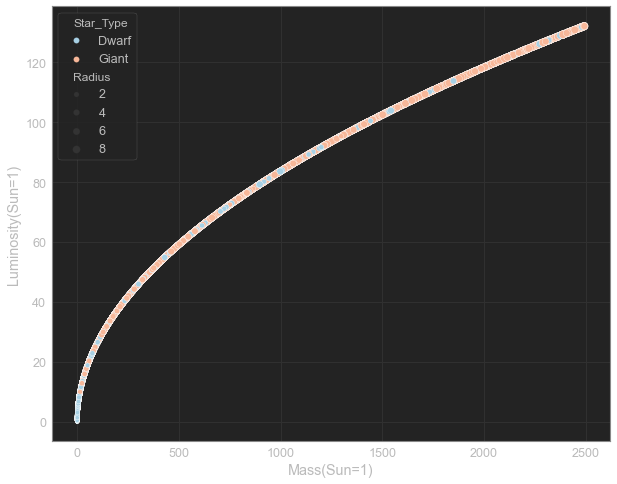

In [644]:
# we can see that bigegr the mass of star in comparation
# with the sun, higher luminosity the star will have

fig = plt.figure(figsize=(10,8))
sns.scatterplot(data = df, x = 'Mass(Sun=1)', y = 'Luminosity(Sun=1)', hue = 'Star_Type', 
                size = 'Radius', palette = "RdBu_r")

jtplot.style(theme='monokai', gridlines= '-.')
plt.show()


#### Mass by Star Type

No handles with labels found to put in legend.


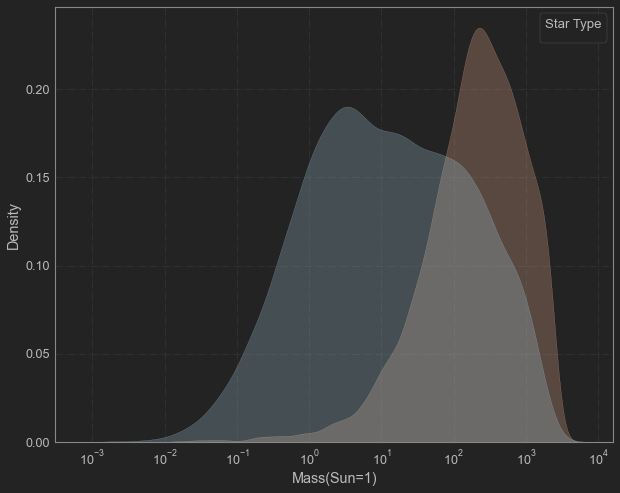

In [645]:
# Giants stars have higher mass


plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Mass(Sun=1)', hue = 'Star_Type', palette = "RdBu_r", shade = True, log_scale=10)
plt.title('')
plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()

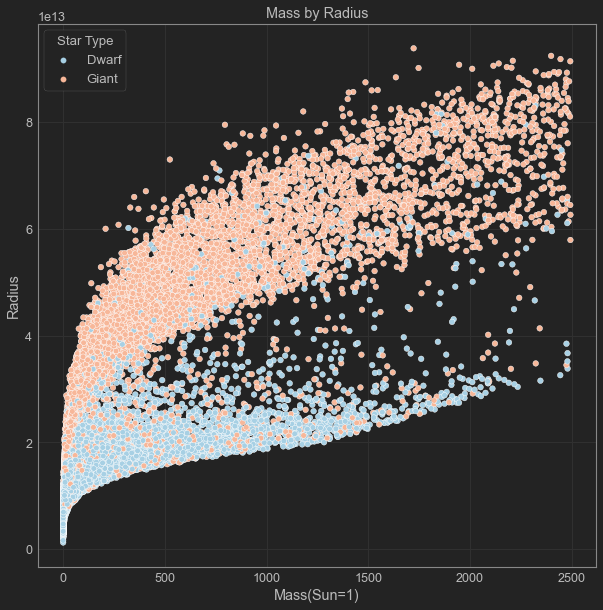

In [646]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = df, x = 'Mass(Sun=1)', y = 'Radius', hue = 'Star_Type', 
                palette = "RdBu_r")
plt.title('Mass by Radius')
plt.legend(title = 'Star Type', fontsize = 'medium', title_fontsize = 'medium')
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()


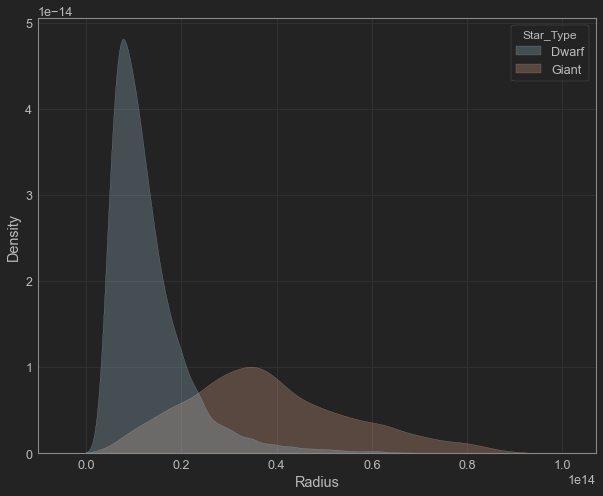

In [647]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Radius', hue = 'Star_Type', palette = "RdBu_r", shade = True)
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()


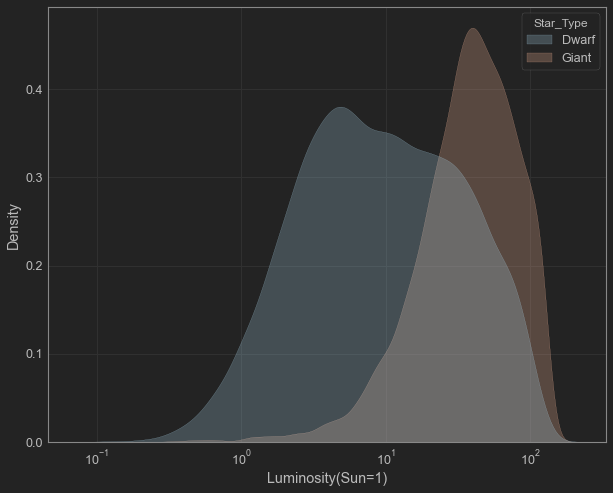

In [648]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Luminosity(Sun=1)', hue = 'Star_Type', palette = "RdBu_r", shade = True, log_scale=10)
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()


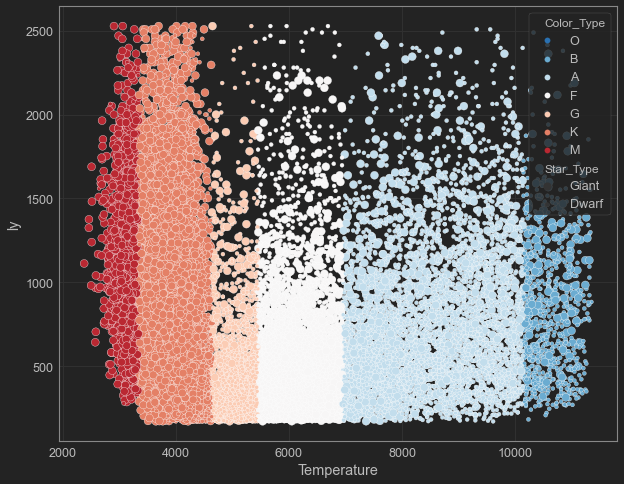

In [649]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df, x = 'Temperature', y = 'ly', hue = 'Color_Type', size = 'Star_Type', 
                size_order = taille_order, x_bins=3, hue_order = bright_order , palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()



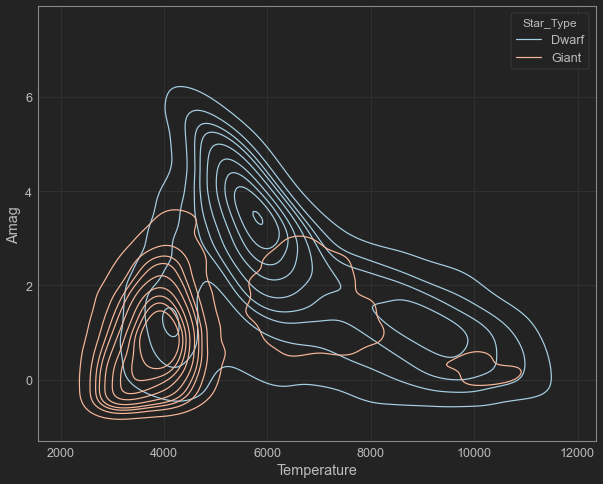

In [650]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Temperature', y = 'Amag', hue = 'Star_Type', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()


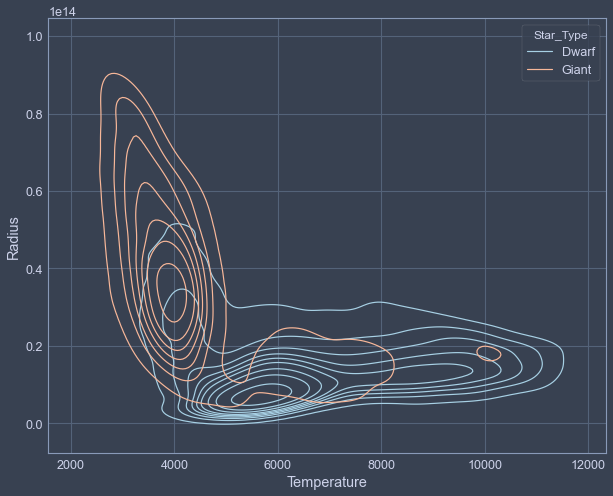

In [651]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Temperature', y = 'Radius', hue = 'Star_Type', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()


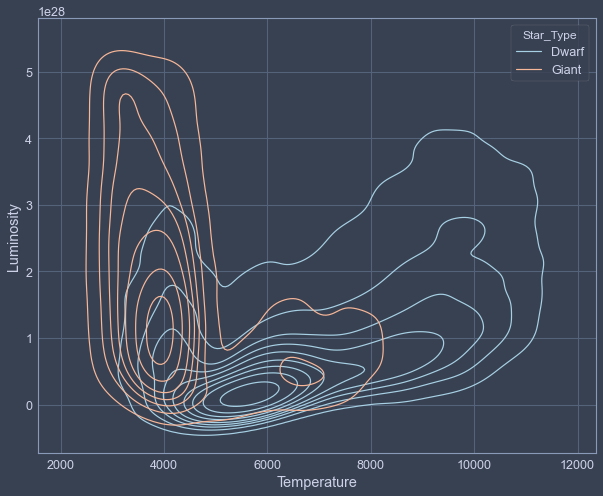

In [652]:
plt.figure(figsize=(10,8))
sns.kdeplot(data = df, x = 'Temperature', y = 'Luminosity', hue = 'Star_Type', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()

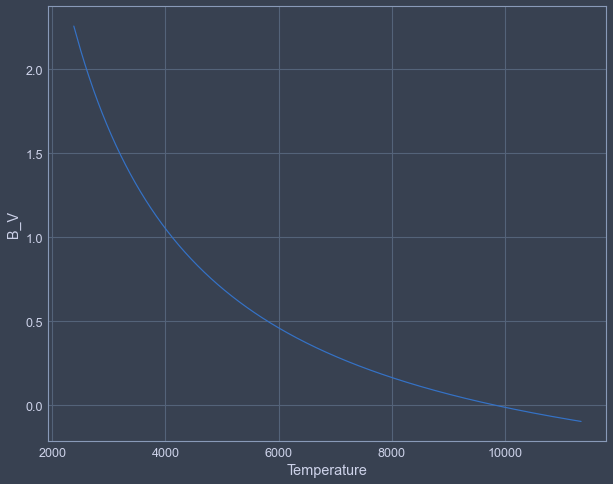

In [653]:
plt.figure(figsize=(10,8))
sns.lineplot(data = df, x = 'Temperature', y = 'B_V', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()


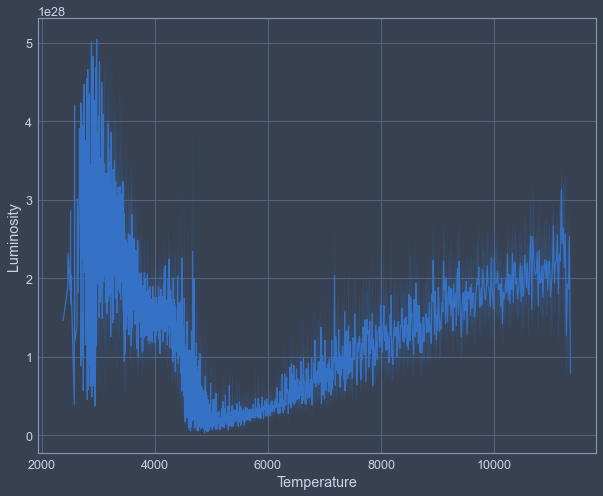

In [654]:
plt.figure(figsize=(10,8))
sns.lineplot(data = df, x = 'Temperature', y = 'Luminosity', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()

```python

plt.figure(figsize=(10,8))
sns.lineplot(data = df, x = 'Luminosity(Sun=1)', y = 'B_V', palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()

```

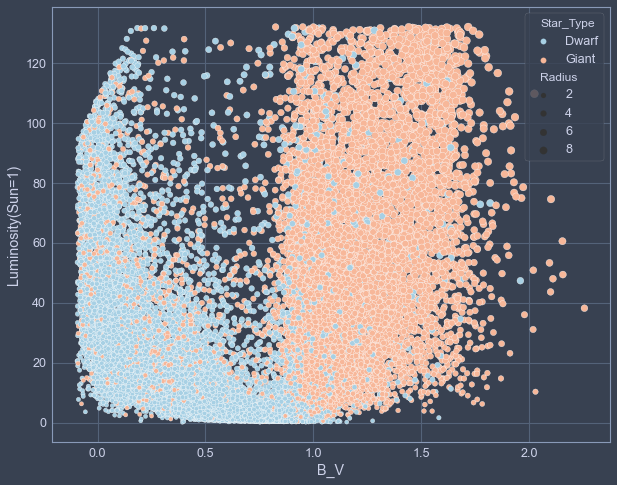

In [655]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df, x = 'B_V', y = 'Luminosity(Sun=1)', size = 'Radius', 
                hue = 'Star_Type', x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()


In [656]:
df

Vmag      Plx  e_Plx    B_V SpType    Distance           ly      Amag  \
0      8.06  0.00775   0.97  0.370    F0V  129.032263   420.645179  2.506509   
1      8.55  0.00287   1.11  0.902  G8III  348.432084  1135.888594  0.839409   
2      8.59  0.01076   1.10  0.489    F6V   92.936805   302.973984  3.749061   
3      8.43  0.00406   1.16  1.484  K4III  246.305432   802.955709  1.472630   
4      8.80  0.00349   1.48  1.128  K0III  286.532962   934.097457  1.514127   
...     ...      ...    ...    ...    ...         ...          ...       ...   
32046  7.76  0.00707   1.03  0.462    F5V  141.442718   461.103261  2.007097   
32047  9.29  0.00721   1.33  0.496    F5V  138.696260   452.149808  3.579676   
32048  8.05  0.00624   1.17  1.157  K2III  160.256423   522.435938  2.025923   
32049  9.26  0.00268   1.36  0.521    F5V  373.134334  1216.417930  1.400674   
32050  7.69  0.00660   0.92  1.110  K2III  151.515160   493.939421  1.787720   

       Temperature    Luminosity  Luminosity(Sun=1)  Mass(Sun=1)  Radius(sun)  \
0      6504.587128  3.164961e+27           8.267924     9.765509     0.022850   
1      4371.146705  1.469630e+28          38.391599   210.559268     0.071303   
2      5864.350739  1.007737e+27           2.632543     0.990040     0.006559   
3      3216.878450  8.202000e+27          21.426333    65.583966     0.029286   
4      3836.580043  7.894435e+27          20.622870    60.757538     0.033618   
...            ...           ...                ...          ...          ...   
32046  5998.307890  5.013408e+27          13.096676    24.503276     0.033378   
32047  5830.592144  1.177881e+27           3.077014     1.352574     0.007623   
32048  3777.304318  4.927229e+27          12.871549    23.668110     0.020658   
32049  5713.134442  8.763998e+27          22.894456    74.879447     0.055575   
32050  3874.316910  6.135982e+27          16.029211    36.705088     0.026387   

             Radius Star_Type Color_Type  
0      1.021937e+13     Dwarf          F  
1      3.276937e+13     Giant          K  
2      6.396070e+12     Dwarf          F  
3      3.326478e+13     Giant          M  
4      2.736376e+13     Giant          K  
...             ...       ...        ...  
32046  1.394753e+13     Dwarf          F  
32047  6.955006e+12     Dwarf          F  
32048  2.195730e+13     Giant          K  
32049  1.936137e+13     Dwarf          F  
32050  2.388946e+13     Giant          K  

[32051 rows x 16 columns]

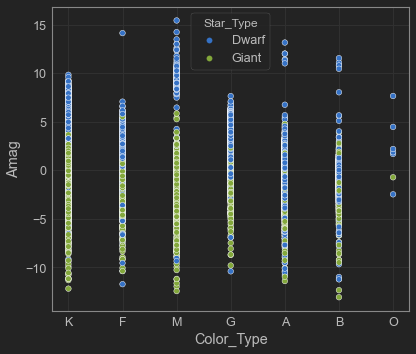

In [657]:
sns.scatterplot(data = df_clean, x = 'Color_Type', y = 'Amag', hue = 'Star_Type')
jtplot.style(theme='monokai', gridlines= '-.', figsize=(10,10))
plt.show()

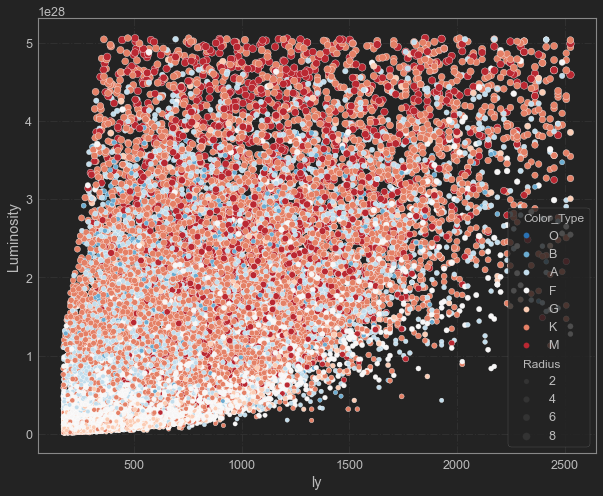

In [658]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df, x = 'ly', y = 'Luminosity', hue = 'Color_Type', size ='Radius',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()

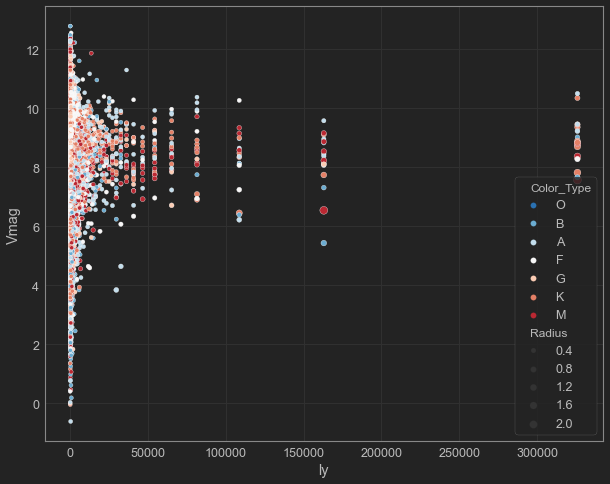

In [659]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_clean, x = 'ly', y = 'Vmag', hue = 'Color_Type', size ='Radius',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='monokai')

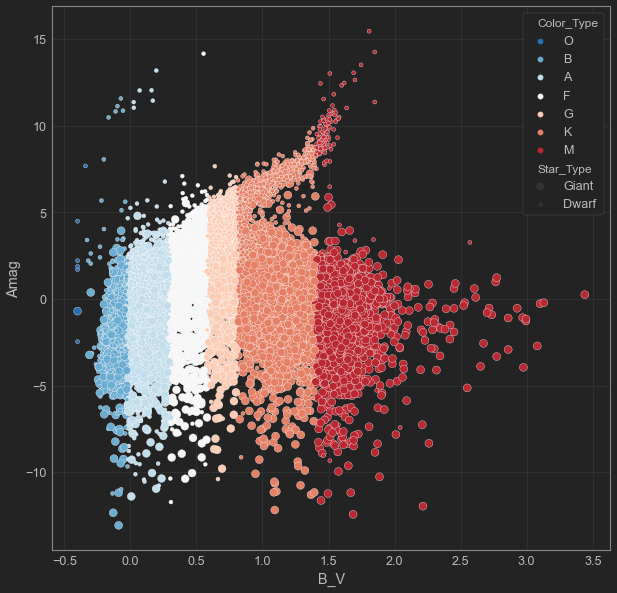

In [660]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = df_clean, x = 'B_V', y = 'Amag', hue = 'Color_Type', size ='Star_Type',
                size_order= taille_order, hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()

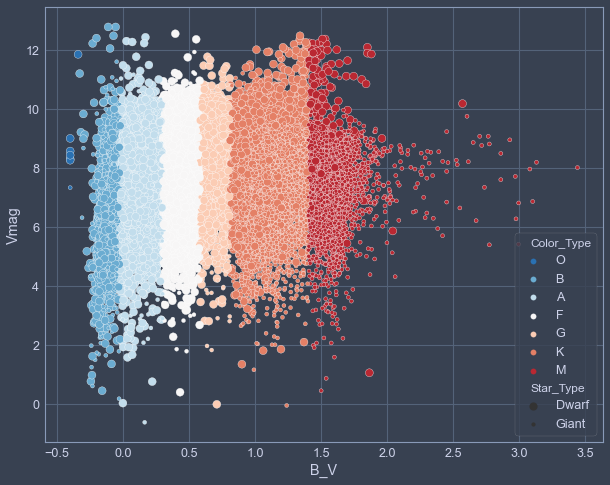

In [661]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_clean, x = 'B_V', y = 'Vmag', hue = 'Color_Type', size ='Star_Type',
                hue_order= bright_order ,x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='oceans16')
plt.show()

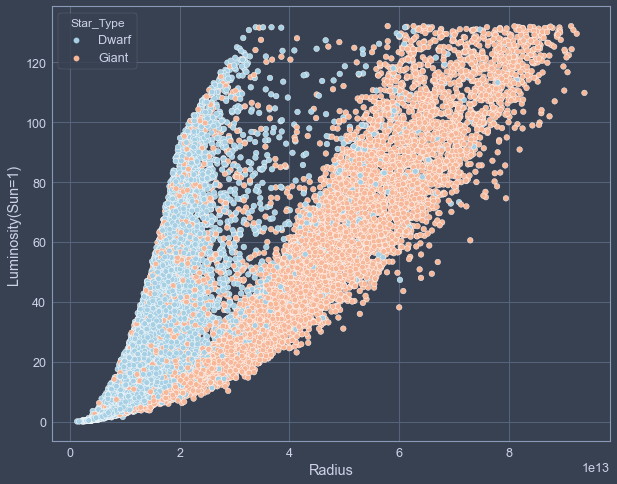

In [662]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df, x = 'Radius', y = 'Luminosity(Sun=1)', hue = 'Star_Type', x_bins=3, palette = "RdBu_r")
plt.grid('-.')
jtplot.style(theme='monokai')
plt.show()


In [663]:
df.head()

Vmag      Plx  e_Plx    B_V SpType    Distance           ly      Amag  \
0  8.06  0.00775   0.97  0.370    F0V  129.032263   420.645179  2.506509   
1  8.55  0.00287   1.11  0.902  G8III  348.432084  1135.888594  0.839409   
2  8.59  0.01076   1.10  0.489    F6V   92.936805   302.973984  3.749061   
3  8.43  0.00406   1.16  1.484  K4III  246.305432   802.955709  1.472630   
4  8.80  0.00349   1.48  1.128  K0III  286.532962   934.097457  1.514127   

   Temperature    Luminosity  Luminosity(Sun=1)  Mass(Sun=1)  Radius(sun)  \
0  6504.587128  3.164961e+27           8.267924     9.765509     0.022850   
1  4371.146705  1.469630e+28          38.391599   210.559268     0.071303   
2  5864.350739  1.007737e+27           2.632543     0.990040     0.006559   
3  3216.878450  8.202000e+27          21.426333    65.583966     0.029286   
4  3836.580043  7.894435e+27          20.622870    60.757538     0.033618   

         Radius Star_Type Color_Type  
0  1.021937e+13     Dwarf          F  
1  3.276937e+13     Giant          K  
2  6.396070e+12     Dwarf          F  
3  3.326478e+13     Giant          M  
4  2.736376e+13     Giant          K

## Get dummies

#### Let's create a boolean column for our star type 

In [664]:
df['Target'] = np.where(df.Star_Type == 'Giant', 0,1)

In [665]:
df.Target.value_counts()

1    19620
0    12431
Name: Target, dtype: int64

Giants = 0

Dwarf = 1

#### Should we balance the data ?

In [666]:
# separate the label 
df_giants = df.query('Target == 0').shape[0]
df_dwarf = df.query('Target == 1').shape[0]

In [667]:
print(f'The proportion of the dwarf datapoints is: {round(df_dwarf/df.shape[0],2)*100}%' )
print(f'And the giant datapoints is : {round(df_giants/df.shape[0],2)*100}%')

The proportion of the dwarf datapoints is: 61.0%
And the giant datapoints is : 39.0%


#### Seeing their 2/3 proportion...it's not really essential to balanced it

#### but if we want we cant do it:

In [668]:
# Numbers of rows of Giants and Dwarfs

#num_of_giant = df_giants.shape[0]
#num_of_dwarf = df_dwarfs.shape[0]
#print("Giants(0):",num_of_giant)
#print("Dwarfs(1):",num_of_dwarf)

In [669]:
# Downsample majority class
#df_dwarfs_balanced = resample(df_dwarfs, 
                                 #replace=False,    # sample without replacement
                                 #n_samples=num_of_giant,     # to match minority class
                                 #random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
#df_balanced = pd.concat([df_dwarfs_balanced, df_giants])

In [670]:
#df_balanced.Target.value_counts()

In [671]:
#df = df_balanced 

### Let's see the correlation

<AxesSubplot:>

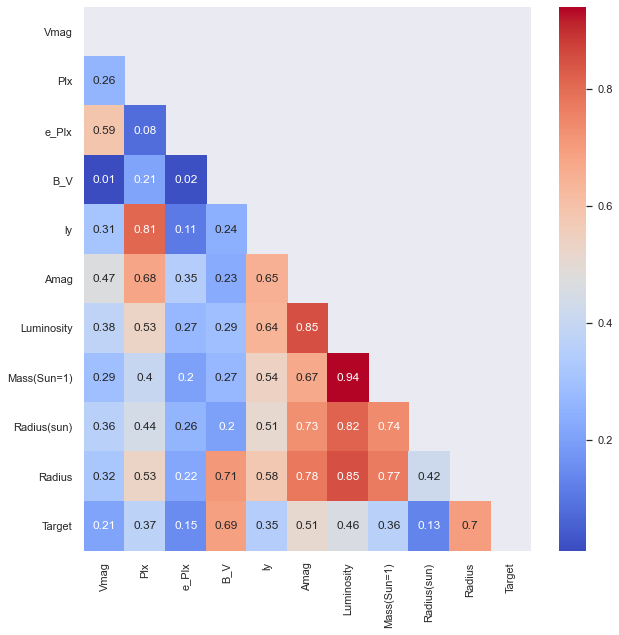

In [767]:
### Heatmap to see the corr between the columns

corr_matrix = df.corr().abs().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

#### Dropping high correleted columns 

In [768]:
# Luminosity has at least 3 places with multicollinearity

df.drop('Luminosity', axis = 1, inplace = True)

<AxesSubplot:>

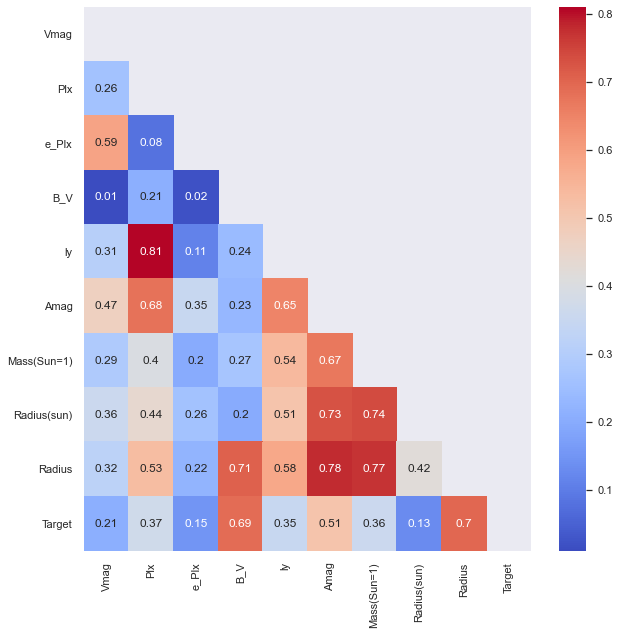

In [769]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [770]:
# Luminosity(Sun) also has high multicollinearity

df.drop('Luminosity(Sun=1)', axis = 1, inplace = True)


KeyError: "['Luminosity(Sun=1)'] not found in axis"

<AxesSubplot:>

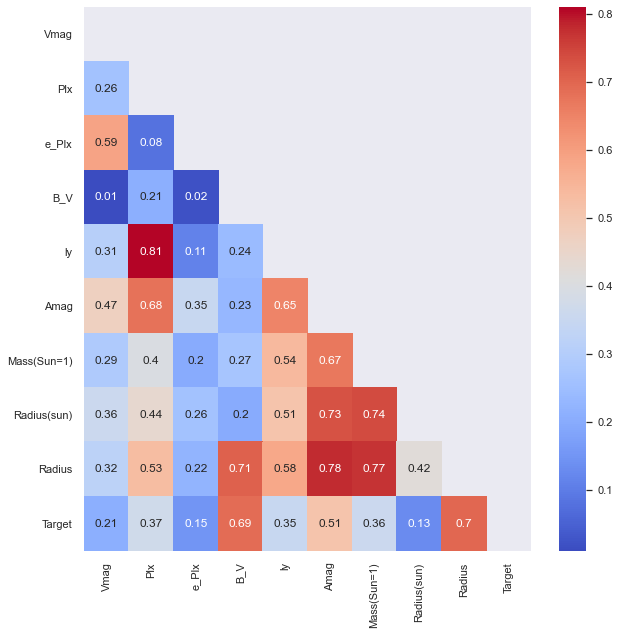

In [771]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [772]:
# Temperature has high collinearity

df.drop('Temperature', axis = 1, inplace = True)

KeyError: "['Temperature'] not found in axis"

<AxesSubplot:>

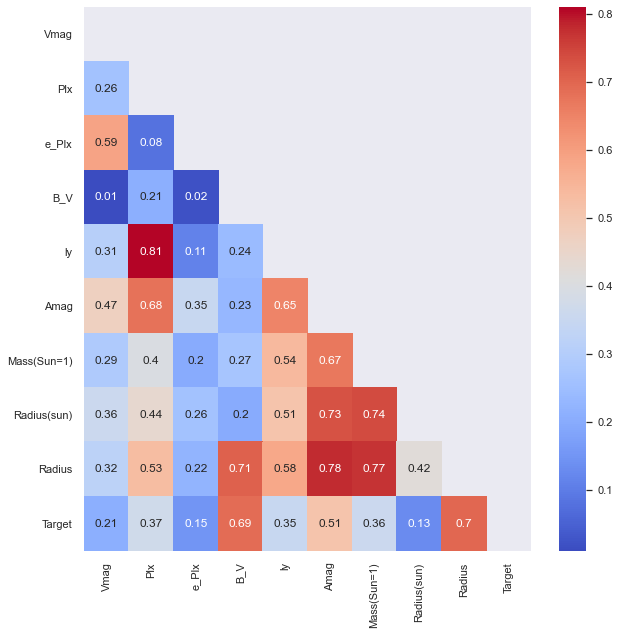

In [773]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [774]:
# At last we can drop it

df.drop('Distance', axis = 1, inplace = True)

KeyError: "['Distance'] not found in axis"

<AxesSubplot:>

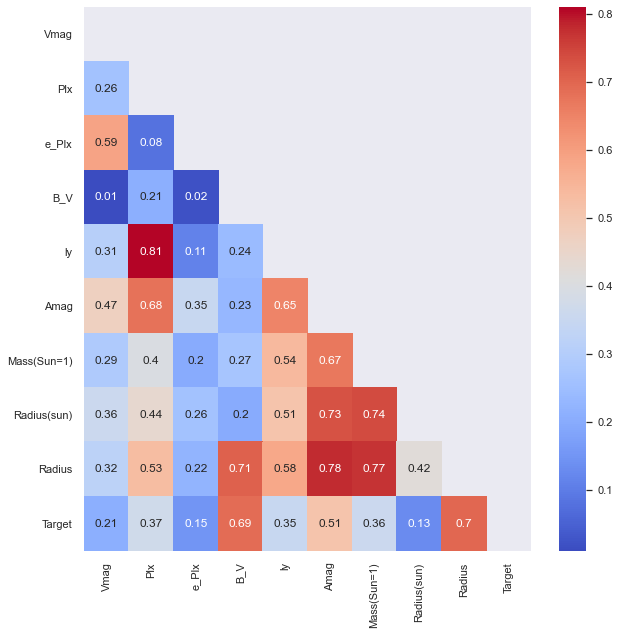

In [775]:
### Let's see the corr between the columns

corr_matrix = df.corr().abs().round(2)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap= 'coolwarm', annot=True)

In [776]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32051 entries, 0 to 32050
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         32051 non-null  float32
 1   Plx          32051 non-null  float64
 2   e_Plx        32051 non-null  float32
 3   B_V          32051 non-null  float32
 4   ly           32051 non-null  float64
 5   Amag         32051 non-null  float64
 6   Mass(Sun=1)  32051 non-null  float64
 7   Radius(sun)  32051 non-null  float64
 8   Radius       32051 non-null  float64
 9   Color_Type   32051 non-null  object 
 10  Target       32051 non-null  int32  
dtypes: float32(3), float64(6), int32(1), object(1)
memory usage: 2.2+ MB


#### The SpType columns has too many uniques values and is too big for get dummies

So lets drop it for the moment

In [777]:
df.drop('SpType', axis = 1, inplace = True)

KeyError: "['SpType'] not found in axis"

In [778]:
df.drop('Star_Type', axis = 1, inplace = True)

KeyError: "['Star_Type'] not found in axis"

#### Converting object type

In [779]:
df_dummy = pd.get_dummies(data = df, columns = ['Color_Type'])

In [780]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32051 entries, 0 to 32050
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vmag          32051 non-null  float32
 1   Plx           32051 non-null  float64
 2   e_Plx         32051 non-null  float32
 3   B_V           32051 non-null  float32
 4   ly            32051 non-null  float64
 5   Amag          32051 non-null  float64
 6   Mass(Sun=1)   32051 non-null  float64
 7   Radius(sun)   32051 non-null  float64
 8   Radius        32051 non-null  float64
 9   Target        32051 non-null  int32  
 10  Color_Type_A  32051 non-null  uint8  
 11  Color_Type_B  32051 non-null  uint8  
 12  Color_Type_F  32051 non-null  uint8  
 13  Color_Type_G  32051 non-null  uint8  
 14  Color_Type_K  32051 non-null  uint8  
 15  Color_Type_M  32051 non-null  uint8  
dtypes: float32(3), float64(6), int32(1), uint8(6)
memory usage: 2.1 MB


In [781]:
df_dummy.head()

Vmag      Plx  e_Plx    B_V           ly      Amag  Mass(Sun=1)  \
0  8.06  0.00775   0.97  0.370   420.645179  2.506509     9.765509   
1  8.55  0.00287   1.11  0.902  1135.888594  0.839409   210.559268   
2  8.59  0.01076   1.10  0.489   302.973984  3.749061     0.990040   
3  8.43  0.00406   1.16  1.484   802.955709  1.472630    65.583966   
4  8.80  0.00349   1.48  1.128   934.097457  1.514127    60.757538   

   Radius(sun)        Radius  Target  Color_Type_A  Color_Type_B  \
0     0.022850  1.021937e+13       1             0             0   
1     0.071303  3.276937e+13       0             0             0   
2     0.006559  6.396070e+12       1             0             0   
3     0.029286  3.326478e+13       0             0             0   
4     0.033618  2.736376e+13       0             0             0   

   Color_Type_F  Color_Type_G  Color_Type_K  Color_Type_M  
0             1             0             0             0  
1             0             0             1             0  
2             1             0             0             0  
3             0             0             0             1  
4             0             0             1             0

In [782]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### Splitting my test and train 

In [783]:
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop('Target', axis = 1),
                                                   df_dummy.Target, test_size = 1/5,
                                                   random_state = 42,
                                                   stratify = df.Target)

#### Standar Scaling our data

In [784]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [785]:
X_train_scaled = scaler.transform(X_train)

In [786]:
X_test_scaled = scaler.transform(X_test)

#### Let's create a function to display the confusion matrix 

In [787]:
def cf_matrix(cf_matrix, model_name):
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{value_1}\n\n{value_2}\n\n{value_3}" for value_1, value_2, value_3 
          in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    fig = plt.figure(figsize=(4, 4))
    sns.set(font_scale=1) 
    cmap = sns.color_palette('vlag', as_cmap=True)


    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=cmap)
    plt.title(model_name, fontweight='bold', fontsize=15, fontname = 'candara')

    fig.tight_layout()
    return plt.show()

#### Logistic Regression

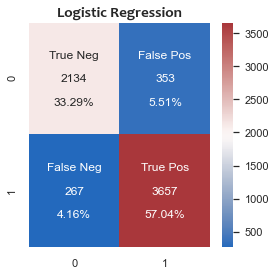

Accuracy score is : 90.33%
Precision score is : 91.20%
Recall score is : 93.20%
F1 score is :92.19%


In [788]:
model_logistic = LogisticRegression(max_iter = 1e5)

model_logistic.fit(X_train_scaled, y_train)


y_pred1 = model_logistic.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred1), 'Logistic Regression' )

print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred1)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred1)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred1)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred1)))


#### Decision Tree

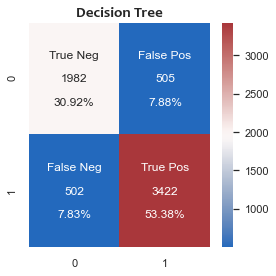

Accuracy score is : 84.29%
Precision score is : 87.14%
Recall score is : 87.21%
F1 score is :87.17%


In [789]:
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train_scaled, y_train)
y_pred2 = model_tree.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred2), 'Decision Tree')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred2)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred2)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred2)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred2)))


<AxesSubplot:>

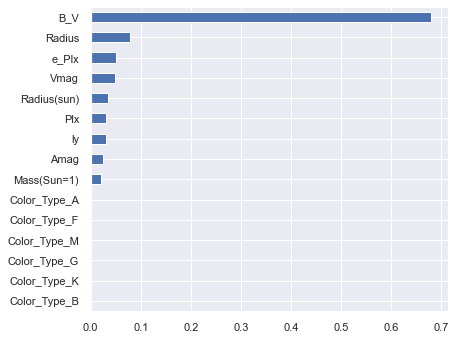

In [790]:
pd.Series(model_tree.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### KNN

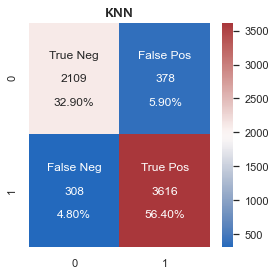

Accuracy score is : 89.30%
Precision score is : 90.54%
Recall score is : 92.15%
F1 score is :91.34%


In [791]:
model_knn = KNeighborsClassifier(5, weights = 'distance')
model_knn.fit(X_train_scaled, y_train)

y_pred3 = model_knn.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred3), 'KNN')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred3)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred3)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred3)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred3)))


#### SVC

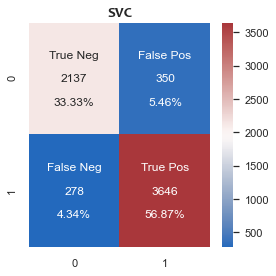

Accuracy score is : 90.20%
Precision score is : 91.24%
Recall score is : 92.92%
F1 score is :92.07%


In [792]:
model_svc = SVC()
model_svc.fit(X_train_scaled, y_train)
y_pred4 = model_svc.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred4), 'SVC')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred4)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred4)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred4)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred4)))


#### Gaussian NB

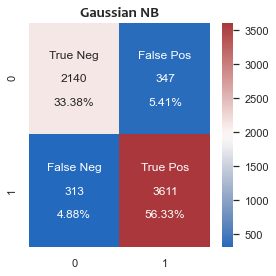

Accuracy score is : 89.71%
Precision score is : 91.23%
Recall score is : 92.02%
F1 score is :91.63%


In [793]:
model_NB = GaussianNB()
model_NB.fit(X_train_scaled, y_train)
y_pred5 = model_NB.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred5), 'Gaussian NB')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred5)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred5)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred5)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred5)))


#### Random Forest

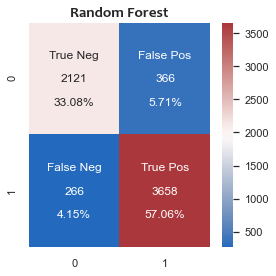

Accuracy score is : 90.14%
Precision score is : 90.90%
Recall score is : 93.22%
F1 score is :92.05%


In [794]:
model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train_scaled, y_train)
y_pred6 = model_rf.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred6), 'Random Forest')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred6)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred6)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred6)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred6)))


<AxesSubplot:>

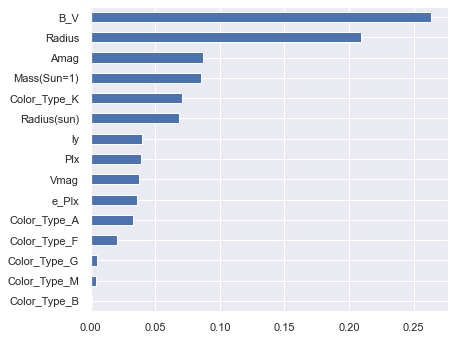

In [795]:
pd.Series(model_rf.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### AdaBoost

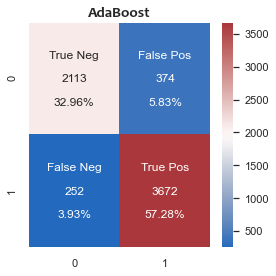

Accuracy score is : 90.24%
Precision score is : 90.76%
Recall score is : 93.58%
F1 score is :92.15%


In [796]:
model_ad = AdaBoostClassifier()
model_ad.fit(X_train_scaled, y_train)
y_pred7 = model_ad.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred7), 'AdaBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred7)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred7)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred7)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred7)))



<AxesSubplot:>

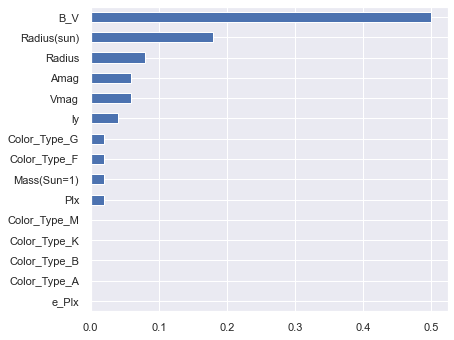

In [797]:
pd.Series(model_ad.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### XGBoost

[22:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


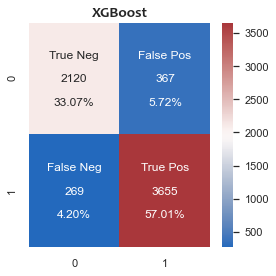

Accuracy score is : 90.08%
Precision score is : 90.88%
Recall score is : 93.14%
F1 score is :92.00%


In [798]:
model_xg = XGBClassifier()
model_xg.fit(X_train_scaled, y_train)
y_pred8 = model_xg.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred8), 'XGBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred8)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred8)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred8)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred8)))


<AxesSubplot:>

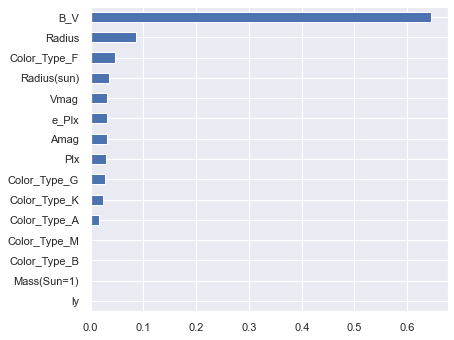

In [799]:
pd.Series(model_xg.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### LightGBM

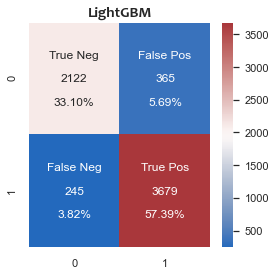

Accuracy score is : 90.49%
Precision score is : 90.97%
Recall score is : 93.76%
F1 score is :92.34%


In [800]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train_scaled, y_train)
y_pred9 = model_lgbm.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred9), 'LightGBM')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred9)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred9)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred9)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred9)))


<AxesSubplot:>

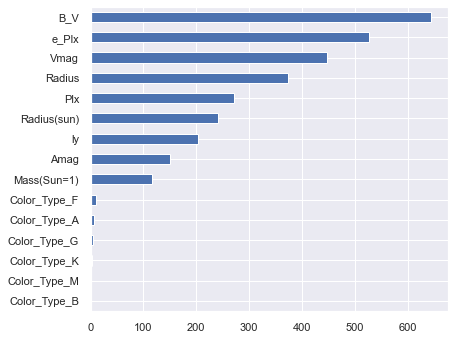

In [801]:
pd.Series(model_lgbm.feature_importances_, index = X_train.columns).sort_values().plot.barh()

#### CatBoost

In [802]:
model_cat=CatBoostClassifier()
model_cat.fit(X_train_scaled, y_train)
y_pred10 = model_cat.predict(X_test_scaled)


Learning rate set to 0.041166
0:	learn: 0.6522750	total: 53.2ms	remaining: 53.1s
1:	learn: 0.6147851	total: 76.3ms	remaining: 38.1s
2:	learn: 0.5818161	total: 96.2ms	remaining: 32s
3:	learn: 0.5516044	total: 121ms	remaining: 30.1s
4:	learn: 0.5240445	total: 143ms	remaining: 28.5s
5:	learn: 0.4998104	total: 171ms	remaining: 28.3s
6:	learn: 0.4788551	total: 189ms	remaining: 26.9s
7:	learn: 0.4600557	total: 208ms	remaining: 25.8s
8:	learn: 0.4425517	total: 225ms	remaining: 24.8s
9:	learn: 0.4269283	total: 249ms	remaining: 24.7s
10:	learn: 0.4129416	total: 266ms	remaining: 23.9s
11:	learn: 0.4002856	total: 288ms	remaining: 23.7s
12:	learn: 0.3891165	total: 306ms	remaining: 23.2s
13:	learn: 0.3793488	total: 324ms	remaining: 22.8s
14:	learn: 0.3700584	total: 340ms	remaining: 22.3s
15:	learn: 0.3616724	total: 364ms	remaining: 22.4s
16:	learn: 0.3544041	total: 384ms	remaining: 22.2s
17:	learn: 0.3478089	total: 402ms	remaining: 21.9s
18:	learn: 0.3417141	total: 419ms	remaining: 21.6s
19:	learn:

162:	learn: 0.2627271	total: 3.57s	remaining: 18.3s
163:	learn: 0.2626929	total: 3.6s	remaining: 18.3s
164:	learn: 0.2626550	total: 3.62s	remaining: 18.3s
165:	learn: 0.2626078	total: 3.64s	remaining: 18.3s
166:	learn: 0.2625273	total: 3.66s	remaining: 18.3s
167:	learn: 0.2624468	total: 3.68s	remaining: 18.2s
168:	learn: 0.2623888	total: 3.71s	remaining: 18.2s
169:	learn: 0.2623364	total: 3.73s	remaining: 18.2s
170:	learn: 0.2622595	total: 3.76s	remaining: 18.2s
171:	learn: 0.2621775	total: 3.78s	remaining: 18.2s
172:	learn: 0.2621399	total: 3.8s	remaining: 18.2s
173:	learn: 0.2620713	total: 3.82s	remaining: 18.1s
174:	learn: 0.2620104	total: 3.84s	remaining: 18.1s
175:	learn: 0.2619106	total: 3.86s	remaining: 18.1s
176:	learn: 0.2618686	total: 3.88s	remaining: 18s
177:	learn: 0.2617929	total: 3.91s	remaining: 18.1s
178:	learn: 0.2617333	total: 3.93s	remaining: 18s
179:	learn: 0.2616586	total: 3.95s	remaining: 18s
180:	learn: 0.2616000	total: 3.97s	remaining: 18s
181:	learn: 0.2615283	

322:	learn: 0.2532031	total: 6.89s	remaining: 14.4s
323:	learn: 0.2531432	total: 6.92s	remaining: 14.4s
324:	learn: 0.2530842	total: 6.94s	remaining: 14.4s
325:	learn: 0.2530213	total: 6.96s	remaining: 14.4s
326:	learn: 0.2529402	total: 6.98s	remaining: 14.4s
327:	learn: 0.2528646	total: 7s	remaining: 14.3s
328:	learn: 0.2527994	total: 7.02s	remaining: 14.3s
329:	learn: 0.2527364	total: 7.04s	remaining: 14.3s
330:	learn: 0.2526761	total: 7.05s	remaining: 14.3s
331:	learn: 0.2526014	total: 7.08s	remaining: 14.3s
332:	learn: 0.2525398	total: 7.1s	remaining: 14.2s
333:	learn: 0.2524770	total: 7.13s	remaining: 14.2s
334:	learn: 0.2524212	total: 7.14s	remaining: 14.2s
335:	learn: 0.2523532	total: 7.17s	remaining: 14.2s
336:	learn: 0.2522944	total: 7.18s	remaining: 14.1s
337:	learn: 0.2522381	total: 7.2s	remaining: 14.1s
338:	learn: 0.2521763	total: 7.22s	remaining: 14.1s
339:	learn: 0.2521450	total: 7.24s	remaining: 14s
340:	learn: 0.2520713	total: 7.26s	remaining: 14s
341:	learn: 0.2519795

487:	learn: 0.2438778	total: 10.1s	remaining: 10.6s
488:	learn: 0.2438270	total: 10.1s	remaining: 10.6s
489:	learn: 0.2437495	total: 10.2s	remaining: 10.6s
490:	learn: 0.2436836	total: 10.2s	remaining: 10.6s
491:	learn: 0.2436346	total: 10.2s	remaining: 10.5s
492:	learn: 0.2435795	total: 10.2s	remaining: 10.5s
493:	learn: 0.2435459	total: 10.2s	remaining: 10.5s
494:	learn: 0.2435195	total: 10.3s	remaining: 10.5s
495:	learn: 0.2434568	total: 10.3s	remaining: 10.4s
496:	learn: 0.2434041	total: 10.3s	remaining: 10.4s
497:	learn: 0.2433498	total: 10.3s	remaining: 10.4s
498:	learn: 0.2432804	total: 10.3s	remaining: 10.4s
499:	learn: 0.2432047	total: 10.4s	remaining: 10.4s
500:	learn: 0.2431339	total: 10.4s	remaining: 10.3s
501:	learn: 0.2430878	total: 10.4s	remaining: 10.3s
502:	learn: 0.2430494	total: 10.4s	remaining: 10.3s
503:	learn: 0.2429929	total: 10.4s	remaining: 10.3s
504:	learn: 0.2429167	total: 10.4s	remaining: 10.2s
505:	learn: 0.2428640	total: 10.5s	remaining: 10.2s
506:	learn: 

653:	learn: 0.2357173	total: 13.4s	remaining: 7.11s
654:	learn: 0.2356581	total: 13.5s	remaining: 7.09s
655:	learn: 0.2356127	total: 13.5s	remaining: 7.07s
656:	learn: 0.2355957	total: 13.5s	remaining: 7.05s
657:	learn: 0.2355728	total: 13.5s	remaining: 7.03s
658:	learn: 0.2355328	total: 13.5s	remaining: 7.01s
659:	learn: 0.2354910	total: 13.6s	remaining: 6.99s
660:	learn: 0.2354605	total: 13.6s	remaining: 6.97s
661:	learn: 0.2354048	total: 13.6s	remaining: 6.95s
662:	learn: 0.2353716	total: 13.6s	remaining: 6.92s
663:	learn: 0.2353157	total: 13.6s	remaining: 6.9s
664:	learn: 0.2352709	total: 13.7s	remaining: 6.89s
665:	learn: 0.2352273	total: 13.7s	remaining: 6.87s
666:	learn: 0.2351700	total: 13.7s	remaining: 6.85s
667:	learn: 0.2350995	total: 13.7s	remaining: 6.83s
668:	learn: 0.2350551	total: 13.8s	remaining: 6.8s
669:	learn: 0.2350311	total: 13.8s	remaining: 6.78s
670:	learn: 0.2349570	total: 13.8s	remaining: 6.76s
671:	learn: 0.2349122	total: 13.8s	remaining: 6.74s
672:	learn: 0.

816:	learn: 0.2285641	total: 17.6s	remaining: 3.94s
817:	learn: 0.2285451	total: 17.6s	remaining: 3.92s
818:	learn: 0.2285027	total: 17.6s	remaining: 3.9s
819:	learn: 0.2284817	total: 17.7s	remaining: 3.88s
820:	learn: 0.2284123	total: 17.7s	remaining: 3.86s
821:	learn: 0.2283679	total: 17.7s	remaining: 3.84s
822:	learn: 0.2283307	total: 17.8s	remaining: 3.82s
823:	learn: 0.2282915	total: 17.8s	remaining: 3.8s
824:	learn: 0.2282507	total: 17.8s	remaining: 3.78s
825:	learn: 0.2282329	total: 17.8s	remaining: 3.76s
826:	learn: 0.2281944	total: 17.9s	remaining: 3.73s
827:	learn: 0.2281634	total: 17.9s	remaining: 3.71s
828:	learn: 0.2281214	total: 17.9s	remaining: 3.69s
829:	learn: 0.2280545	total: 17.9s	remaining: 3.67s
830:	learn: 0.2280173	total: 17.9s	remaining: 3.65s
831:	learn: 0.2279899	total: 18s	remaining: 3.62s
832:	learn: 0.2279562	total: 18s	remaining: 3.6s
833:	learn: 0.2279111	total: 18s	remaining: 3.58s
834:	learn: 0.2278781	total: 18s	remaining: 3.56s
835:	learn: 0.2278253	t

980:	learn: 0.2221334	total: 21.4s	remaining: 414ms
981:	learn: 0.2220793	total: 21.4s	remaining: 392ms
982:	learn: 0.2220285	total: 21.4s	remaining: 370ms
983:	learn: 0.2219868	total: 21.4s	remaining: 349ms
984:	learn: 0.2219556	total: 21.5s	remaining: 327ms
985:	learn: 0.2218913	total: 21.5s	remaining: 305ms
986:	learn: 0.2218432	total: 21.5s	remaining: 283ms
987:	learn: 0.2218070	total: 21.5s	remaining: 261ms
988:	learn: 0.2217794	total: 21.6s	remaining: 240ms
989:	learn: 0.2217439	total: 21.6s	remaining: 218ms
990:	learn: 0.2216934	total: 21.6s	remaining: 196ms
991:	learn: 0.2216360	total: 21.6s	remaining: 174ms
992:	learn: 0.2215810	total: 21.6s	remaining: 153ms
993:	learn: 0.2215400	total: 21.7s	remaining: 131ms
994:	learn: 0.2214767	total: 21.7s	remaining: 109ms
995:	learn: 0.2214385	total: 21.7s	remaining: 87.2ms
996:	learn: 0.2213957	total: 21.7s	remaining: 65.4ms
997:	learn: 0.2213355	total: 21.7s	remaining: 43.6ms
998:	learn: 0.2212847	total: 21.8s	remaining: 21.8ms
999:	lea

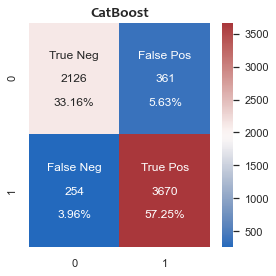

Accuracy score is : 90.41%
Precision score is : 91.04%
Recall score is : 93.53%
F1 score is :92.27%


In [803]:


cf_matrix(confusion_matrix(y_test, y_pred10), 'CatBoost')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred10)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred10)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred10)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred10)))


#### Gradient Boosting for classification

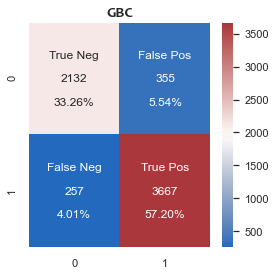

Accuracy score is : 90.45%
Precision score is : 91.17%
Recall score is : 93.45%
F1 score is :92.30%


In [804]:
model_gbc = GradientBoostingClassifier()
model_gbc.fit(X_train_scaled, y_train)
y_pred11 = model_gbc.predict(X_test_scaled)

cf_matrix(confusion_matrix(y_test, y_pred11), 'GBC')
print('Accuracy score is : {0:.2%}'.format(accuracy_score(y_test, y_pred11)))
print('Precision score is : {0:.2%}'.format(precision_score(y_test, y_pred11)))
print('Recall score is : {0:.2%}'.format(recall_score(y_test, y_pred11)))
print('F1 score is :{0:.2%}'.format(f1_score(y_test, y_pred11)))


<AxesSubplot:>

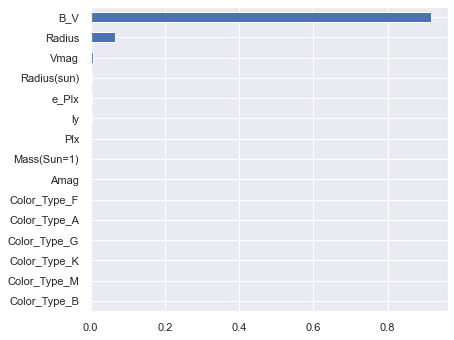

In [805]:
pd.Series(model_gbc.feature_importances_, index = X_train.columns).sort_values().plot.barh()

### Summary

In [806]:
a, p, r, f = [], [], [], []
for model in [model_logistic, model_tree, model_knn, model_svc, model_NB, model_rf, model_ad, model_xg, model_lgbm, model_gbc]:
    a.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    p.append(precision_score(y_test, model.predict(X_test_scaled)))
    r.append(recall_score(y_test, model.predict(X_test_scaled)))
    f.append(f1_score(y_test, model.predict(X_test_scaled)))

In [807]:
model_score = pd.DataFrame([a, p, r, f], columns = ['LR', 'DT', 'KNN', 'SVC', 'NB', 'RF', 'AB', 'XGB', 'LGBM', 'GBC']).T.sort_values(
    by=3, ascending = False).rename(columns = {0: 'Accurancy',
                                              1: 'Precision',
                                              2: 'Recall',
                                              3: 'F1'})

model_score

Accurancy  Precision    Recall        F1
LGBM   0.904851   0.909743  0.937564  0.923444
GBC    0.904539   0.911735  0.934506  0.922980
LR     0.903291   0.911970  0.931957  0.921855
AB     0.902355   0.907563  0.935780  0.921455
SVC    0.902043   0.912412  0.929154  0.920707
RF     0.901419   0.909046  0.932212  0.920483
XGB    0.900796   0.908752  0.931448  0.919960
NB     0.897052   0.912329  0.920234  0.916265
KNN    0.892996   0.905358  0.921509  0.913362
DT     0.842926   0.871403  0.872069  0.871736

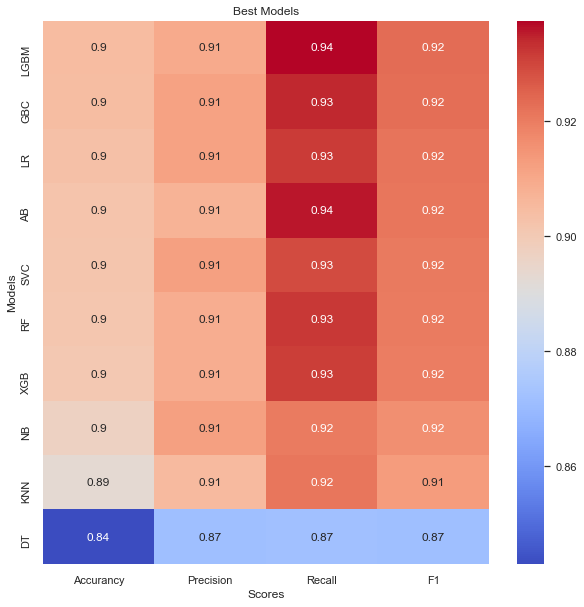

In [808]:
plt.figure(figsize=(10,10))
sns.heatmap(model_score, annot=True, cmap = 'coolwarm')
plt.title('Best Models')
plt.xlabel('Scores')
plt.ylabel('Models')
plt.show()

In [809]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


TP = True Positive – The model predicted the positive class correctly, to be a positive class.

FP = False Positive – The model predicted the negative class incorrectly, to be a positive class.

FN = False Negative – The model predicted the positive class incorrectly, to be the negative class.

TN = True Negative – The model predicted the negative class correctly, to be the negative class

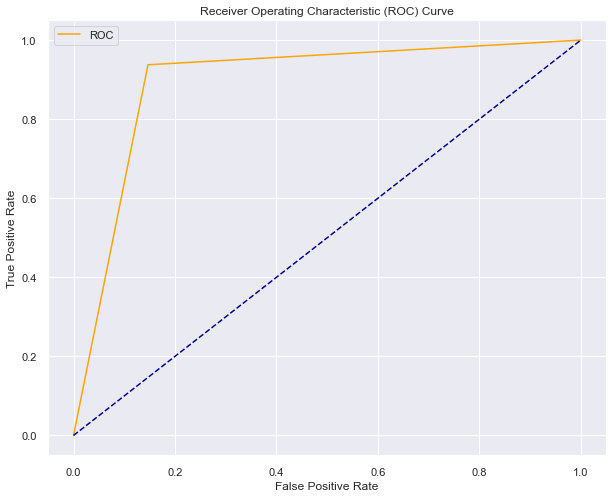

In [811]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred9)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [812]:
roc_auc_score(y_test, y_pred6)


0.8925233845968455

In [813]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred9)

3.2863742714018933

In [823]:
from pycaret.classification import *
cl = setup(data=df_dummy, target='Target')


In [815]:
best = compare_models()

In [824]:
lgbm = create_model('lightgbm')

In [825]:
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

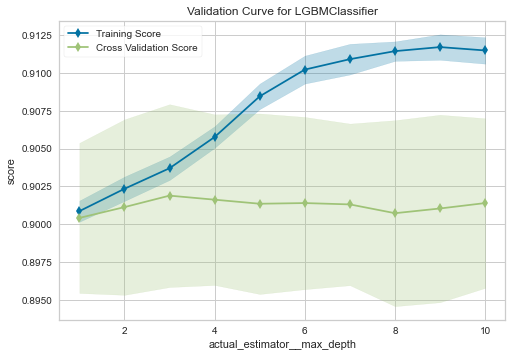

In [826]:
# AUC plot
plot_model(lgbm, plot = 'auc')

# Decision Boundary
plot_model(lgbm, plot = 'boundary')

# Precision Recall Curve
plot_model(lgbm, plot = 'pr')

# Validation Curve
plot_model(lgbm, plot = 'vc')

In [819]:
from sklearn.cluster import KMeans

In [820]:
from yellowbrick.cluster import KElbowVisualizer

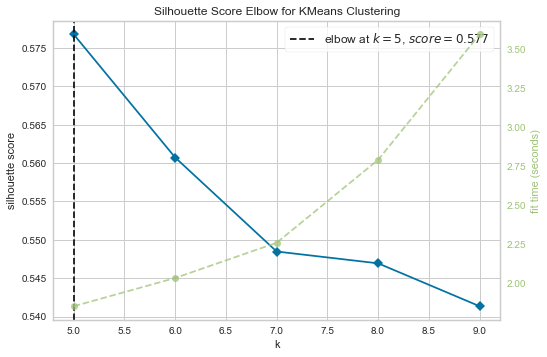

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [822]:
model = KMeans()


visualizer = KElbowVisualizer(model, k = (5,10), metric = 'silhouette')

visualizer.fit(df_dummy)
visualizer.poof()

## With PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(0.85)
pca.fit(df_dummy)

In [ ]:
df_pca = pca.transform(df_dummy)

In [ ]:
df_pca = pd.DataFrame(df_pca, columns=['PC'+str(i) for i in range(1, df_pca.shape[1]+1)])

In [ ]:
df_pca